In [1]:
import importlib
import JeffUtils
importlib.reload(JeffUtils)

<module 'JeffUtils' from 'C:\\Users\\j3ff1\\Documents\\School Work\\MLProjects\\TelecomChurnAnalysis\\JeffUtils.py'>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import scipy
import re
from typing import Union, List

In [3]:
pd.set_option('display.max_columns', None)

we set a predetermined random seed so our experiment results can be easily replicated 

In [4]:
RANDOM_SEED = 1337

# Loading Raw Data

Data downloaded from: https://www.kaggle.com/datasets/abhinav89/telecom-customer?resource=download. The data has 100 columns and 100,000 data points

In [38]:
raw_data = pd.read_csv('telecomChurn.zip')
raw_data.shape

(100000, 100)

The description mentions that customer_id is the primary key, hence we set it so and clean up column names

In [39]:
raw_data = raw_data.set_index('Customer_ID')
raw_data.columns = map(str.lower,raw_data.columns)
raw_data = raw_data[np.sort(raw_data.columns)]

## Handling column descriptions

Since there is literally a hundred columns in this dataset, we may want to group similar columns together and analyze them group by group for an easier time. We just want a quick look so we won't use any complicated state of the art NLP methods, and stick with the tried and true, quick and dirty method of tfidf+kmeans clustering.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import gensim
import spacy

### read-in column descriptions

column descriptions are scraped straight from the kaggle website via beautifulsoup. It's been packaged in this repository for convenience's sake. 

In [8]:
col_desc = pd.read_json('columnDescriptions.json',orient='index')[0].rename('col_desc').to_frame()

In [9]:
#set it to all lower case like we did column names in raw data
col_desc.index = col_desc.index.str.lower()
#pull out customer_id since it is just a primary key
col_desc = col_desc.drop(['customer_id'])
#pull out churn since it is our target variable
col_desc = col_desc.drop(['churn'])

In [11]:
col_desc.head(5)

,col_desc
rev_mean,Mean monthly revenue (charge amount)
mou_mean,Mean number of monthly minutes of use
totmrc_mean,Mean total monthly recurring charge
da_mean,Mean number of directory assisted calls
ovrmou_mean,Mean overage minutes of use


### Preprocess column descriptions

In [10]:
#Remove stop words
col_desc['clean_desc'] = (
    col_desc['col_desc']
    .apply(gensim.parsing.preprocessing.remove_stopwords)
)

#Remove characters that are not decimals,
#not letters, and not white space
col_desc['clean_desc'] = (
    col_desc['clean_desc']
    .str.replace('[^a-zA-Z0-9_ \%]','')
)
#Replace double whitespace with single space
#created from operation above
col_desc['clean_desc'] = (
    col_desc['clean_desc']
    .str.replace('  ',' ')
)

In [11]:
nlp = spacy.load('en_core_web_sm')
#Tokenize words in the cleaned description and lemmatize them
col_desc['tokenized'] = col_desc['clean_desc'].apply(lambda x: [token.lemma_ for token in nlp(x)])
#Join lemmatized tokens back into single string for ease of use
col_desc['lemmatized'] = col_desc['tokenized'].apply(lambda x: ' '.join(x))

In [12]:
#Transform our column descriptions into a tf-idf matrix so that we have numerical data to work with
tfidf = TfidfVectorizer()
tfidfMatrix = tfidf.fit_transform(col_desc['lemmatized'])

### kmeans grouping

We'll try to cluster similar columns together via K-Means since its quick and dirty.

In [13]:
#import utility functions
from JeffUtils import graph_cluster_wc, graph_elbow

We try values from 5-15 clusters for the number of clusters parameter of K-Means. Any less than 5 would likely not yield much separation between each cluster. Meanwhile, any more clusters than 15 is a little much to go through by hand, hence would make this entire process kind of redundant. 

In [14]:
kmeans = []
for i in range(5,16):
    km = KMeans(n_clusters=i,random_state=RANDOM_SEED)
    km.fit_predict(tfidfMatrix.toarray())
    kmeans.append((i,km.inertia_))

Then determine the elbow of the loss. The elbow is calculated via the second derivative of the loss curve at every point, and the point with the highest second derivative is chosen as our parameter for the number of clusters. From the graph below, we see that the optimal number of clusters would be 6 clusters.

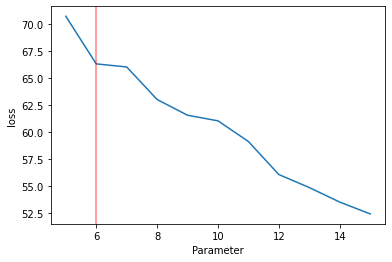

In [15]:
loss = pd.DataFrame(kmeans)[1].rename('loss')
#since the min number of clusters tested started at 5
loss.index = loss.index+5
#graph loss at every point and return optimal point
elbow = graph_elbow(loss) 

we'll use the determined elbow as our n_cluster parameter to run kmeans

In [16]:
kmeans = KMeans(n_clusters=elbow,random_state=RANDOM_SEED)
col_desc['kmeans_class'] = kmeans.fit_predict(tfidfMatrix.toarray())

In [17]:
from JeffUtils import graph_all_cluster_wc

We now graph the 5 most common words appearing in each cluster, with the x axis representing the percentage of column descriptions in the cluster that contains the word in question. Some clusters have clearly defined themes, while others may not. The below summarizes what each column description cluster is likely primarily representing. 

- cluster 0 doesn't seem to have a unified theme, since the percentage of descriptions sharing each common word is very low. The cluster is therefore likely a collection of descriptions that do not fit well into other clusters. We should check this cluster out later on. 
- cluster 1 seems to deal with general call statistics
- cluster 2 deals with statistics relate to minutes
- cluster 3 deals with monthly statistics
- cluster 4 deals with statstics of the customer household
- cluster 5 deals with statistics across the customer's life 

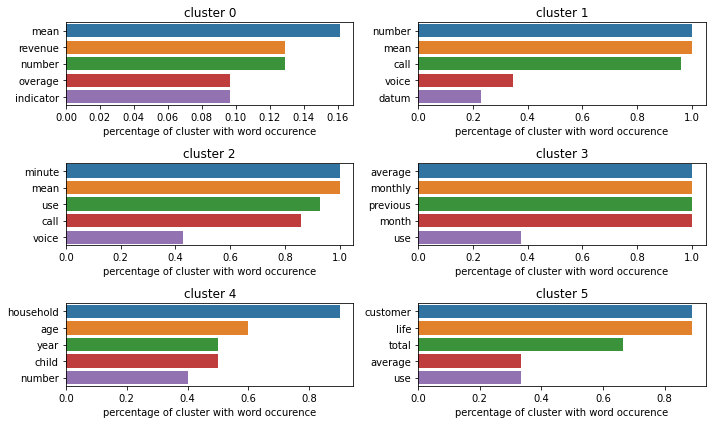

In [19]:
graph_all_cluster_wc(col_desc,'kmeans_class',figsize=(10,6))

We can also use T-SNE with default parameters to reduce our high dimensional dataset to two dimensions, so that we may graph our clusters for a quick sanity check. If the graph shows relatively clear demarcation of clusters, it means our "most common word" analysis from before actually represent each cluster well. If certain clusters do not have clear demarcations, we may need to double check that the clusters should actually be separated, and our K-Means didn't make a mistake. 

In [20]:
from sklearn.manifold import TSNE

In [21]:
tsne = TSNE(n_components=2,
            perplexity = 30,
            learning_rate='auto',
            init='pca',
            random_state=RANDOM_SEED)
tsneX = tsne.fit_transform(tfidfMatrix.toarray())

C:\Users\j3ff1\.conda\envs\xgboost\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


It seems like clusters 1 and 2 have very similar descriptions as their datapoints are pretty intermingled, while the other clusters all have relatively more clearly defined clusters. We should double check that cluster 1 and 2 actually contain descriptions of different topics, and our K-Means didn't separate the descriptions within these two clusters due to some mathematical quirk

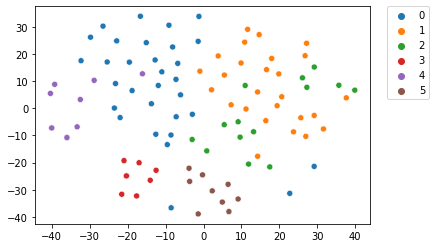

In [22]:
sns.scatterplot(
    x=tsneX[:,0],y=tsneX[:,1],hue=col_desc['kmeans_class'],
    palette=sns.color_palette("tab10")[:col_desc['kmeans_class'].nunique()]
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [73]:
#Helper functions for quality of life later on

def get_clusters_list()->list:
    """returns a list where index corresponds
    to cluster id from kmeans clustering
    """
    clusters = []
    for cluster_id in np.sort(col_desc['kmeans_class'].unique()):
        clusters.append(
            col_desc[col_desc['kmeans_class']==cluster_id].index
        )
    return clusters

def get_col_desc(col_name:Union[str,List[str]])->Union[str,List[str]]:
    """get column description from column name
    """
    return col_desc.loc[col_name]['col_desc']

create a list of clustered column names for easier access and examination

In [19]:
clusters = get_clusters_list()

We randomly sample 5 descriptions from each cluster to avoid being overwhelmed. From these samples, we see:
- Cluster 1 does indeed deal with general call statistics, while cluster 2 deals with statistics related to minutes.
- The reason the two clusters are so similar is because they both deal with a variety of similar statistics, but one breaks down said statistics by calls while the other by minutes. Hence, the K-Means was right to cluster them this way.

In [22]:
get_col_desc(clusters[1]).sample(n=5,random_state=RANDOM_SEED)

da_mean             Mean number of directory assisted calls
blck_dat_mean    Mean number of blocked (failed) data calls
comp_vce_mean          Mean number of completed voice calls
recv_vce_mean           Mean number of received voice calls
attempt_mean                Mean number of attempted calls 
Name: col_desc, dtype: object

In [23]:
get_col_desc(clusters[2]).sample(n=5,random_state=RANDOM_SEED)

mou_cvce_mean    Mean unrounded minutes of use of completed voi...
cc_mou_mean      Mean unrounded minutes of use of customer care...
ovrmou_mean                            Mean overage minutes of use
mou_mean                     Mean number of monthly minutes of use
inonemin_mean    Mean number of inbound calls less than one minute
Name: col_desc, dtype: object

Lastly, a quick look at cluster 0 does confirm our early suspicion that it is a collection of disparate column descriptions

In [27]:
get_col_desc(clusters[0]).sample(n=5,random_state=RANDOM_SEED)

datovr_mean                Mean revenue of data overage
refurb_new                  Handset: refurbished or new
rev_mean           Mean monthly revenue (charge amount)
dualband                                       Dualband
iwylis_vce_mean                                       N
Name: col_desc, dtype: object

# Data Examination

In [23]:
#simple utility function to print plots
from JeffUtils import jeff_histplot 

In [40]:
#creae a dataframe copy to store all our changes in
clean_data = raw_data.copy()

## Missing values

First we take a look at what values may be missing from our data

In [20]:
import networkx as nx

In [21]:
percentage_na = (raw_data.isna().sum().sort_values(ascending=False)/raw_data.shape[0])

It seems like the majority of the columns do not have missing values at all. Many that do have missing values, however, can have significant chunks missing. In fact, the column with the highest amount of missing values have nearly 50% of its rows missing. 

(0.0, 30.0)

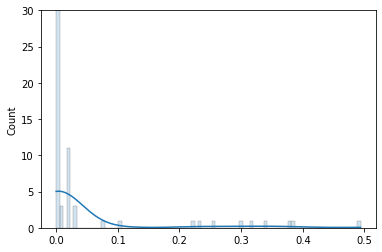

In [24]:
ax = jeff_histplot(percentage_na,kde=True)
ax.set_ylim(0,30)

Lets take a look at columns that have a perfectly correlated missing values (i.e if one feature in the group has missing value, the rest would also for that row). This well let us know how to feed data into our model for prediction and setup our dashboard. 

In [44]:
#get the correlation of missing values between every column
mia_corr = raw_data.isna().corr()

In [45]:
perf_corr_cols = (
    mia_corr
    #Since (col1,col2) shows the same relationship as (col2,col1), 
    #and the diagonal will always be perfectly correlated,
    #we just need the upper triangular of the missing matrix
    .where(np.triu(np.ones(mia_corr.shape),1).astype(bool))
    #get columns whose missingness is perfectly correlated 
    .where(mia_corr==1,np.nan)
    #turn into list of tuples
    .stack().index
)

In [46]:
#create an undirected graph from the data with each column as a node
G = nx.from_pandas_edgelist(perf_corr_cols.to_frame().reset_index(drop=True),0,1)
perf_miss_cols = []

#add each component to a list for easier access
for c in nx.connected_components(G):
    perf_miss_cols.append(c)

In the cell below we see the groups of columns who have perfectly correlated missingness. This means that for each row in our data, if that row has a column with a missing value, all other columns from the same group would also have a missing value in that row as well. Certain interesting observations can be made:

- The miscellaneous info regarding the customer household is likely obtained through an optional survey or indrectly obtained through another avenue. This is because the missingness of features credit card, truck, rv ownership as well as number of children is household all have the exact same missingness when such disparate information shouldn't if they were directly obtained from the customer. These values are therefore likely MCAR (Missing completely at random)
- There is very little (in fact, only one row) customers with missing data on whether their contract included a handset and the related information on said handset if the customer purchased one. 
- In general, these rows that have perfectly correlated missingness have relatviely low percentages compared to other features with missing values (as seen in the later cell), ranging from only 1-2 rows to roughly 3% out of 100,000 rows missing. Since the nubmer of missing values is so small, we may simply use mean or median imputation if needed later on and hope it doesn't affect our model too much.

Text(0.5, 1.0, 'Percentage of Rows Missing in Each Column')

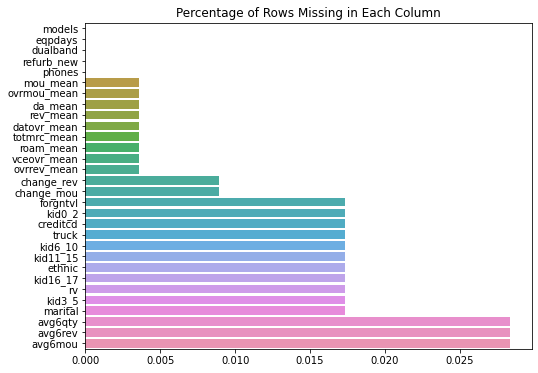

In [47]:
plt.figure(figsize=(8,6))
union_perf_mia = (
    list(set().union(*perf_miss_cols))
)

perf_mia = (
    raw_data.isna().sum()[
        union_perf_mia
    ]/raw_data.shape[0]
).sort_values()

ax = sns.barplot(x=perf_mia,y=perf_mia.index)
ax.set_title('Percentage of Rows Missing in Each Column')

<AxesSubplot:xlabel='months', ylabel='Density'>

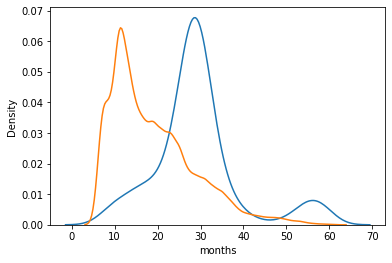

In [125]:
sns.kdeplot(raw_data[raw_data.roam_mean.isna()].months)
sns.kdeplot(raw_data.months)

C:\Users\j3ff1\.conda\envs\xgboost\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='income', ylabel='count'>

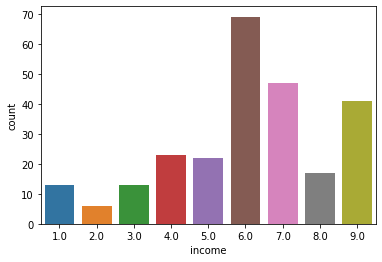

In [130]:
sns.countplot(raw_data[raw_data.roam_mean.isna()].income)

C:\Users\j3ff1\.conda\envs\xgboost\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='income', ylabel='count'>

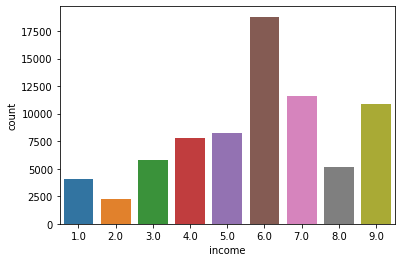

In [129]:
sns.countplot(raw_data.income)

The columns below are other columns that contian missing values but with their missingness not perfectly correlated with any other columns. Unlike the previous columns where some of them have perfectly correlated missingness with each other, these columns have significantly higher percentages of missingness with almost half of the rows in 'numbcars' missing. 

Text(0.5, 1.0, 'Percentage of Rows Missing in Each Column')

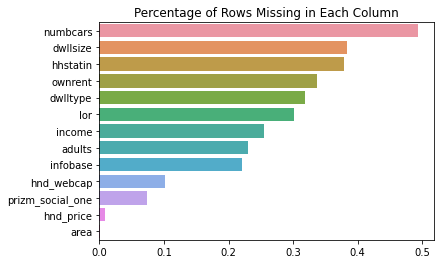

In [53]:
non_perf_mia = (
    raw_data.isna().sum()[
        list(set(raw_data.columns[raw_data.isna().sum()>0])-set(union_perf_mia))
    ]/raw_data.shape[0]
).sort_values(ascending=False)
ax = sns.barplot(x=non_perf_mia,y=non_perf_mia.index)
ax.set_title('Percentage of Rows Missing in Each Column')

In [109]:
raw_data.adults.value_counts().sort_index()

1.0    22299
2.0    23045
3.0    13667
4.0     8803
5.0     4817
6.0     4350
Name: adults, dtype: int64

<AxesSubplot:xlabel='income', ylabel='Density'>

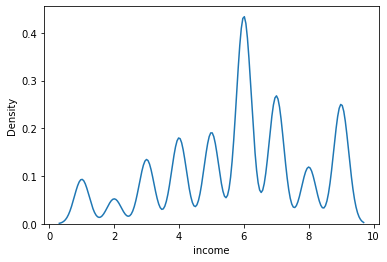

In [103]:
sns.kdeplot(raw_data.income)

### Cleaning Missingness

Some of the missing values in certain columns are MNAR (Missing not at Random) which can be fixed. For example from the cell below, we see that the 'numbcars' column has no 0 value, meaning all missing values are likely customers with no cars. We support this idea in the cell after by the fact that urban areas with public transport (and therefore less likelihood of car ownership) have higher missingness. We can therefore replace missing values with 0. 

In [29]:
raw_data.numbcars.value_counts()

1.0    25586
2.0    21358
3.0     3690
Name: numbcars, dtype: int64

<AxesSubplot:xlabel='numbcars', ylabel='area'>

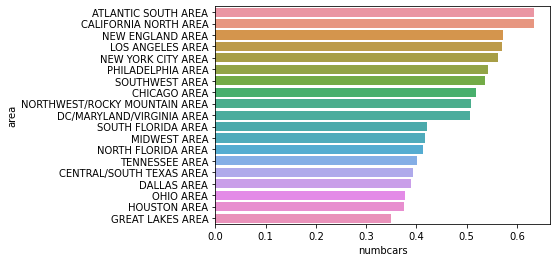

In [91]:
cars_mia = (
    raw_data.groupby('area')['numbcars']
    .apply(lambda x: x.isna().sum()/x.shape[0])
    .sort_values(ascending=False)
)
sns.barplot(x=cars_mia,y=cars_mia.index)

In [41]:
clean_data['numbcars'] = raw_data['numbcars'].fillna(0)

In [100]:
raw_data.dtypes[raw_data.dtypes=='object']

area                object
asl_flag            object
crclscod            object
creditcd            object
dualband            object
dwllsize            object
dwlltype            object
ethnic              object
hhstatin            object
hnd_webcap          object
infobase            object
kid0_2              object
kid11_15            object
kid16_17            object
kid3_5              object
kid6_10             object
marital             object
new_cell            object
ownrent             object
prizm_social_one    object
refurb_new          object
dtype: object

In [56]:
clusters[0]

Index(['rev_mean', 'totmrc_mean', 'ovrrev_mean', 'vceovr_mean', 'datovr_mean',
       'iwylis_vce_mean', 'months', 'new_cell', 'crclscod', 'asl_flag',
       'prizm_social_one', 'area', 'dualband', 'refurb_new', 'hnd_price',
       'phones', 'models', 'hnd_webcap', 'truck', 'rv', 'ownrent', 'lor',
       'dwlltype', 'marital', 'infobase', 'income', 'numbcars', 'dwllsize',
       'forgntvl', 'ethnic', 'creditcd'],
      dtype='object')

We elect not to use any other common imputation methods such as mean/median imputation or SMOTE since many of the missing data are qualitative data that have little relation to the other features, hence any data imputation method would likely be inaccurate and confuse our model. 

## Categorical Column Examination

Since our data contains non-numeric data, lets explore them to see what we are working with first. From below we see that the majority of these columns are categorical values that need to be dummied, while certain columns such as dwelling size may need to be changed to ordinal. 

In [104]:
str_cols = raw_data.dtypes[raw_data.dtypes=='object'].index
str_col_nuniq = raw_data[str_cols].nunique()
#ignore binary columns
get_col_desc(str_col_nuniq[str_col_nuniq>2].index)

area                                  Geogrpahic area 
crclscod                             Credit class code
dualband                                      Dualband
dwllsize                                Dwelling size 
ethnic                          Ethnicity roll-up code
hhstatin            Premier household status indicator
hnd_webcap                      Handset web capability
marital                                Marital Status 
new_cell                           New cell phone user
prizm_social_one              Social group letter only
Name: col_desc, dtype: object

In [132]:
col_desc[['col_desc']].T

,rev_mean,mou_mean,totmrc_mean,da_mean,ovrmou_mean,ovrrev_mean,vceovr_mean,datovr_mean,roam_mean,change_mou,change_rev,drop_vce_mean,drop_dat_mean,blck_vce_mean,blck_dat_mean,unan_vce_mean,unan_dat_mean,plcd_vce_mean,plcd_dat_mean,recv_vce_mean,recv_sms_mean,comp_vce_mean,comp_dat_mean,custcare_mean,ccrndmou_mean,cc_mou_mean,inonemin_mean,threeway_mean,mou_cvce_mean,mou_cdat_mean,mou_rvce_mean,owylis_vce_mean,mouowylisv_mean,iwylis_vce_mean,mouiwylisv_mean,peak_vce_mean,peak_dat_mean,mou_peav_mean,mou_pead_mean,opk_vce_mean,opk_dat_mean,mou_opkv_mean,mou_opkd_mean,drop_blk_mean,attempt_mean,complete_mean,callfwdv_mean,callwait_mean,months,uniqsubs,actvsubs,new_cell,crclscod,asl_flag,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,prizm_social_one,area,dualband,refurb_new,hnd_price,phones,models,hnd_webcap,truck,rv,ownrent,lor,dwlltype,marital,adults,infobase,income,numbcars,hhstatin,dwllsize,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays
col_desc,Mean monthly revenue (charge amount),Mean number of monthly minutes of use,Mean total monthly recurring charge,Mean number of directory assisted calls,Mean overage minutes of use,Mean overage revenue,Mean revenue of voice overage,Mean revenue of data overage,Mean number of roaming calls,Percentage change in monthly minutes of use vs...,Percentage change in monthly revenue vs previ...,Mean number of dropped (failed) voice calls,Mean number of dropped (failed) data calls,Mean number of blocked (failed) voice calls,Mean number of blocked (failed) data calls,Mean number of unanswered voice calls,Mean number of unanswered data calls,Mean number of attempted voice calls placed,Mean number of attempted data calls placed,Mean number of received voice calls,Mean number of received sms,Mean number of completed voice calls,Mean number of completed data calls,Mean number of customer care calls,Mean rounded minutes of use of customer care c...,Mean unrounded minutes of use of customer care...,Mean number of inbound calls less than one minute,Mean number of three way calls,Mean unrounded minutes of use of completed voi...,Mean unrounded minutes of use of completed dat...,Mean unrounded minutes of use of received voic...,Mean number of outbound wireless to wireless v...,Mean unrounded minutes of use of outbound wire...,N,Mean unrounded minutes of use of inbound wirel...,Mean number of inbound and outbound peak voice...,Mean number of peak data calls,Mean unrounded minutes of use of peak voice calls,Mean unrounded minutes of use of peak data calls,Mean number of off-peak voice calls,Mean number of off-peak data calls,Mean unrounded minutes of use of off-peak voic...,Mean unrounded minutes of use of off-peak data...,Mean number of dropped or blocked calls,Mean number of attempted calls,Mean number of completed calls,Mean number of call forwarding calls,Mean number of call waiting calls,Total number of months in service,Number of unique subscribers in the household,Number of active subscribers in household,New cell phone user,Credit class code,Account spending limit,Total number of calls over the life of the cus...,Total minutes of use over the life of the cust...,Total revenue,Billing adjusted total revenue over the life o...,Billing adjusted total minutes of use over the...,Billing adjusted total number of calls over th...,Average monthly revenue over the life of the c...,Average monthly minutes of use over the life o...,Average monthly number of calls over the life ...,Average monthly minutes of use over the previo...,Average monthly number of calls over the previ...,Average monthly revenue over the previous thre...,Average monthly minutes of use over the previo...,Average monthly number of calls over the previ...,Average monthly revenue over the previous six ...,Social group letter only,Geogrpahic area,Dualband,Handset: refurbished or new,Current handset price,Number of handsets issued,Number of models issued

In [129]:
raw_data.income.value_counts()

6.0    18802
7.0    11597
9.0    10833
5.0     8277
4.0     7790
3.0     5830
8.0     5142
1.0     4033
2.0     2260
Name: income, dtype: int64

In [134]:
raw_data.groupby('crclscod')['income'].median().sort_values()

crclscod
EF    3.0
C5    4.0
Z2    4.0
Z5    4.5
DA    5.0
D5    5.0
D4    5.0
EA    5.0
EC    5.0
CC    5.0
E2    5.0
E4    5.0
EM    5.0
W     5.0
ZA    5.0
Z1    5.0
Z4    5.0
CA    5.0
K     6.0
A     6.0
O     6.0
JF    6.0
U     6.0
U1    6.0
V1    6.0
Y     6.0
Z     6.0
M     6.0
I     6.0
G     6.0
ZY    6.0
A2    6.0
GA    6.0
A3    6.0
E     6.0
D2    6.0
AA    6.0
D     6.0
CY    6.0
C2    6.0
C     6.0
BA    6.0
B2    6.0
B     6.0
P1    6.5
H     6.5
J     7.0
GY    7.0
V     7.0
TP    7.5
L     9.0
IF    NaN
S     NaN
ZF    NaN
Name: income, dtype: float64

## Correlations

Lets take a look at absolute correlation values to see if any particular column already has a high predictive value on churn by itself

In [482]:
corrs = raw_data.corr()
churn_corrs = corrs['churn']

Below we see that most of the columns having low correlation values, hence it doesn't seem like any particular column has high predictive power by itself

<AxesSubplot:xlabel='churn', ylabel='Count'>

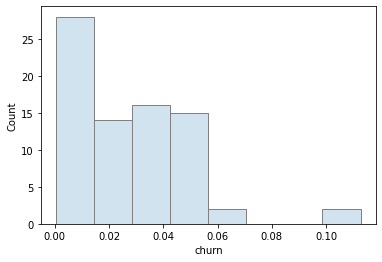

In [483]:
#remove first element since it'll be churn's correlation with itself 
sorted_abs_corr = abs(churn_corrs).sort_values(ascending=False)[1:]
jeff_histplot(sorted_abs_corr) 

It looks like the eqpdays and hnd_price columns have the highest correlation with churn. We'll take a look at these individually

In [471]:
sorted_abs_corr.head(5)

eqpdays          0.112691
hnd_price        0.103184
totmrc_mean      0.068558
mou_mean         0.057027
mou_cvce_mean    0.052042
Name: churn, dtype: float64

Seems like the longer you've been using the same equiment, the more likely you are going to churn

In [476]:
get_col_desc('eqpdays'),churn_corrs['eqpdays']

('Number of days (age) of current equipment', 0.11269140152670142)

Seems like the more expensive the phone your plan is tied to, the less likely you are to churn

In [478]:
get_col_desc('hnd_price'),churn_corrs['hnd_price']

('Current handset price', -0.10318395803125995)

# MONTH

<AxesSubplot:xlabel='months', ylabel='Density'>

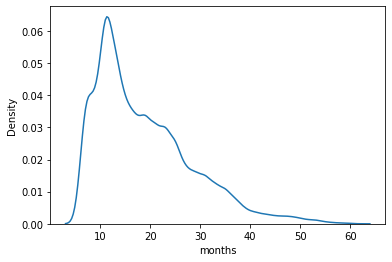

In [112]:
sns.kdeplot(raw_data.months)

In [113]:
raw_data.months.describe()

count    100000.000000
mean         18.833990
std           9.655794
min           6.000000
25%          11.000000
50%          16.000000
75%          24.000000
max          61.000000
Name: months, dtype: float64